In [213]:
!uv add numpy scipy matplotlib seaborn pandas scikit-learn ipynbname

Resolved 57 packages in 16ms
Audited 53 packages in 15ms


In [214]:
from pathlib import Path

runtime_path = Path.cwd()
DATA_DIR = runtime_path / ".." / "data"

In [215]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler

sns.set_theme(style="white", palette="pastel")

np.random.seed(42)  # set for repeatability test

---

# Data Information

In [216]:
df = pd.read_csv(DATA_DIR / "Titanic-Dataset.csv")
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [217]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [218]:
df.select_dtypes(include="object").describe()

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,4,644


In [219]:
df.select_dtypes(exclude="object").describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


---

## Step 1: Handling Missing Values
1. Identify columns that contain missing values.
2. Choose an appropriate strategy for each case:
    - Numerical features: mean or median imputation
    - Categorical features: mode imputation
3. Explain briefly why you chose each method.

In [220]:
# Find the columns which contains missing values
for col in df.columns:
    if df[col].isnull().any():
        print(f"found column with missing values: {col}")

found column with missing values: Age
found column with missing values: Cabin
found column with missing values: Embarked


### Handling missing values in `Age`

In [221]:
df["Age"].describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

Because the proportion of missing values is small (<20%), I chose to impute the missing values using a statistical measure from the Age column.

<Axes: xlabel='Age'>

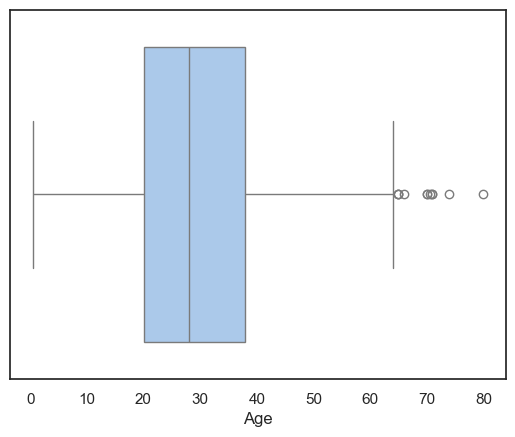

In [222]:
sns.boxplot(df, x="Age")

According to the boxplot diagram, the values in the `Age` column exhibit a left-skewed distribution and contain many outliers; since the mean would be influenced by these outliers, I chose to use the median to impute missing values.

In [223]:
# Impute missing values of `Age` column with median
df["Age_Clean"] = df["Age"].fillna(df["Age"].median())

In [224]:
# Check there is no NaN
age_clean_has_nan = df["Age_Clean"].isna().any()
print(f"`Age_Clean` has NaN? {age_clean_has_nan}.")

# Show at most 5 rows that `Age` is NaN and `Age_Clean` is not NaN
# to check whether the missing values are filled by median
filtered_df = df[df["Age"].isna() & df["Age_Clean"].notna()][["PassengerId", "Age", "Age_Clean"]]
filtered_df.head(5)

`Age_Clean` has NaN? False.


,PassengerId,Age,Age_Clean
5,6,NaN,28.0
17,18,NaN,28.0
19,20,NaN,28.0
26,27,NaN,28.0
28,29,NaN,28.0


### Handling missing values in `Cabin`

In [225]:
df["Cabin"].info()

<class 'pandas.core.series.Series'>
RangeIndex: 891 entries, 0 to 890
Series name: Cabin
Non-Null Count  Dtype 
--------------  ----- 
204 non-null    object
dtypes: object(1)
memory usage: 7.1+ KB


In [226]:
df["Cabin"].describe()

count         204
unique        147
top       B96 B98
freq            4
Name: Cabin, dtype: object

Because missing values account for the majority (>77%), imputing them with any statistical measure would distort the original data distribution; therefore, I chose to fill the missing values with a literal value, creating a new category.

In [227]:
df["Cabin_Clean"] = df["Cabin"].fillna("Unknown")

In [228]:
# Check there is no NaN
cabin_clean_has_nan = df["Cabin_Clean"].isna().any()
print(f"`Cabin_Clean` has NaN? {cabin_clean_has_nan}.")

# Show at most 5 rows that `Cabin` is NaN and `Cabin_Clean` is not NaN
# to check whether the missing values are filled by median
filtered_df = df[df["Cabin"].isna() & df["Cabin_Clean"].notna()][["PassengerId", "Cabin", "Cabin_Clean"]]
filtered_df.head(5)

`Cabin_Clean` has NaN? False.


,PassengerId,Cabin,Cabin_Clean
0,1,NaN,Unknown
2,3,NaN,Unknown
4,5,NaN,Unknown
5,6,NaN,Unknown
7,8,NaN,Unknown


### Handling missing values in `Embarked`

In [229]:
df["Embarked"].info()

<class 'pandas.core.series.Series'>
RangeIndex: 891 entries, 0 to 890
Series name: Embarked
Non-Null Count  Dtype 
--------------  ----- 
889 non-null    object
dtypes: object(1)
memory usage: 7.1+ KB


In [230]:
df["Embarked"].describe()

count     889
unique      3
top         S
freq      644
Name: Embarked, dtype: object

Because there are only two missing values (≪1%), I consider the impact of imputing them with any statistical measure on the original data to be negligible; since this column is categorical, I chose to use the mode for imputation.

In [231]:
df["Embarked_Clean"] = df["Embarked"].fillna(df["Embarked"].mode()[0])

In [232]:
# Check there is no NaN
embarked_clean_has_nan = df["Embarked_Clean"].isna().any()
print(f"`Cabin_Clean` has NaN? {embarked_clean_has_nan}.")

# Show at most 5 rows that `Embarked` is NaN and `Embarked_Clean` is not NaN
# to check whether the missing values are filled by median
filtered_df = df[df["Embarked"].isna() & df["Embarked_Clean"].notna()][["PassengerId", "Embarked", "Embarked_Clean"]]
filtered_df.head(5)

`Cabin_Clean` has NaN? False.


,PassengerId,Embarked,Embarked_Clean
61,62,NaN,S
829,830,NaN,S


---

# Step 2: Noise Detection and Handling
1. Select one numerical feature.
2. Add artificial noise (small random variations) to this feature.
3. Apply a simple noise-handling technique, such as:
    - Moving average
    - Smoothing by aggregation
4. Compare the feature before and after noise handling.

The Fare column contains continuous values; therefore, noise handling was applied to this column.

In [233]:
# Noise intensity is adaptively scaled to the magnitude of the column.
sigma = df["Fare"].std()
print(f"{sigma = }")
scale = 0.01 * sigma
print(f"{scale = }")
df["Fare_with_Noise"] = df["Fare"] + np.random.normal(scale=scale, size=len(df))

sigma = np.float64(49.6934285971809)
scale = np.float64(0.496934285971809)


In [234]:
(df[["PassengerId", "Fare", "Fare_with_Noise"]]).head(10)

,PassengerId,Fare,Fare_with_Noise
0,1,7.2500,7.496834
1,2,71.2833,71.214592
2,3,7.9250,8.246859
3,4,53.1000,53.856846
4,5,8.0500,7.933641
5,6,8.4583,8.341949
6,7,51.8625,52.647265
7,8,21.0750,21.456365
8,9,11.1333,10.900002
9,10,30.0708,30.340417


*** Denoising Similation***

Assume that the noise is an additive white-noise-like noise:
$$
X = S + \epsilon, \qquad \mathbb{E}[\epsilon]=0, \, \mathrm{Var}(\epsilon)=\sigma^2
$$

In [235]:
x = df["Fare_with_Noise"].astype(float)

# Build a "smoothed signal" using quantile bins (no ordering needed)
n_bins = 100

# qcut splits into bins with (roughly) equal counts
bins = pd.qcut(x, q=n_bins, duplicates="drop")

# Use the bin mean as the smoothed value for each sample
s_hat = x.groupby(bins, observed=False).transform("mean")

# Residuals as noise proxy
residual = x - s_hat

# Basic checks
print("Residual mean:", residual.mean())
print("Residual std :", residual.std(ddof=1))
print("Residual var :", residual.var(ddof=1))

# Check if residual depends on the signal (should be near 0)
corr = np.corrcoef(s_hat, residual)[0, 1]
print("Corr(smoothed_signal, residual):", corr)

# Check if residual variance is roughly stable across signal levels
# (group by signal quantiles and measure residual variance in each group)
var_by_level = residual.groupby(pd.qcut(s_hat, q=10, duplicates="drop"), observed=False).var()
print("\nResidual variance by signal level (10 groups):")
print(var_by_level)

# Noise variance estimate (robust, better if there are outliers)
# MAD-based sigma: sigma ≈ 1.4826 * MAD
mad = np.median(np.abs(residual - np.median(residual)))
sigma_robust = 1.4826 * mad
print("Estimated noise std (robust MAD):", sigma_robust)

Residual mean: 1.9139198269632327e-16
Residual std : 12.219049824132773
Residual var : 149.30517860463914
Corr(smoothed_signal, residual): -1.2613289018949937e-16

Residual variance by signal level (10 groups):
Fare_with_Noise
(-0.448, 7.246]         0.504739
(7.246, 7.801]          0.000250
(7.801, 8.353]          0.000273
(8.353, 10.645]         0.005739
(10.645, 14.088]        0.014640
(14.088, 21.35]         0.080476
(21.35, 27.083]         0.055419
(27.083, 39.546]        0.211481
(39.546, 76.307]        1.725077
(76.307, 346.057]    1507.414454
Name: Fare_with_Noise, dtype: float64
Estimated noise std (robust MAD): 0.11254773854067301


In [236]:
df["Fare_Clean"] = df["Fare_with_Noise"] - np.random.normal(scale=sigma_robust, size=len(df))

In [237]:
df[["PassengerId", "Fare", "Fare_with_Noise", "Fare_Clean"]].head(10)

,PassengerId,Fare,Fare_with_Noise,Fare_Clean
0,1,7.2500,7.496834,7.439742
1,2,71.2833,71.214592,71.094540
2,3,7.9250,8.246859,8.115257
3,4,53.1000,53.856846,53.701287
4,5,8.0500,7.933641,7.860630
5,6,8.4583,8.341949,8.360758
6,7,51.8625,52.647265,52.630753
7,8,21.0750,21.456365,21.320575
8,9,11.1333,10.900002,10.991946
9,10,30.0708,30.340417,30.298923


---

# Step 3: Outlier Detection and Handling
1. Detect outliers in at least one numerical feature using:
    - Z-score method or
    - Visualization (boxplot)
2. Handle outliers by:
    - Removing them or
    - Transforming the feature
3. Justify your decision in 1–2 sentences.

### Detect outliers in `Age_Clean`

<Axes: xlabel='Age_Clean', ylabel='Count'>

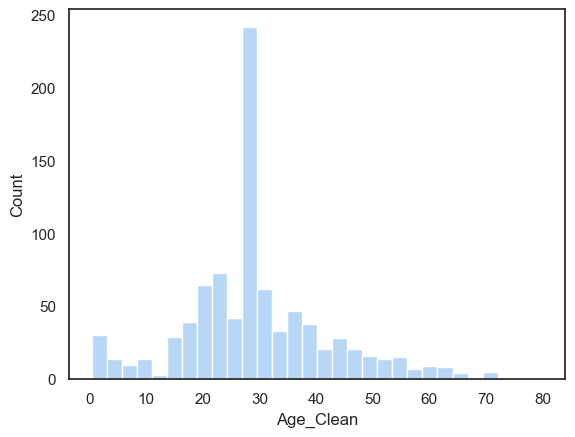

In [238]:
sns.histplot(df, x="Age_Clean")

<Axes: xlabel='Age_Clean'>

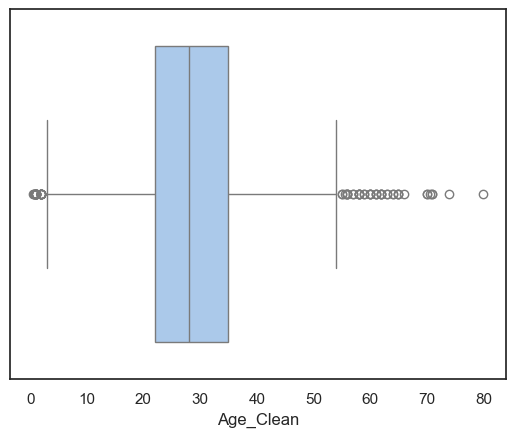

In [239]:
sns.boxplot(df, x="Age_Clean")

Because the distribution of `age_clean` is close to normal and the outlier values are still realistic (e.g., no ages below 0 or above 100, and a minimal impact on the expected value), it is reasonable to use a z-score to constrain ages within a closed interval and replace outliers with the interval’s minimum and maximum values.

In [240]:
mu = df["Age_Clean"].mean()
sigma = df["Age_Clean"].std(ddof=1)
z = (df["Age_Clean"] - mu) / sigma

# Typical noise: |z| > 3
z_th = 3

lower_bound = mu - z_th * sigma
upper_bound = mu + z_th * sigma

df["Age_Clean_Zcapped"] = df["Age_Clean"].clip(
    lower=lower_bound,
    upper=upper_bound
)

In [241]:
filtered_lower_df = df[(df["Age_Clean"] != df["Age_Clean_Zcapped"]) & (df["Age_Clean"] < lower_bound)]
filtered_lower_df[["PassengerId", "Age", "Age_Clean", "Age_Clean_Zcapped"]].head(3)

,PassengerId,Age,Age_Clean,Age_Clean_Zcapped


In [242]:
filtered_upper_df = df[(df["Age_Clean"] != df["Age_Clean_Zcapped"]) & (df["Age_Clean"] > upper_bound)]
filtered_upper_df[["PassengerId", "Age", "Age_Clean", "Age_Clean_Zcapped"]].head(3)

,PassengerId,Age,Age_Clean,Age_Clean_Zcapped
96,97,71.0,71.0,68.420672
116,117,70.5,70.5,68.420672
493,494,71.0,71.0,68.420672


### Detect outliers in `Fare_Clean`

<Axes: xlabel='Fare_Clean', ylabel='Count'>

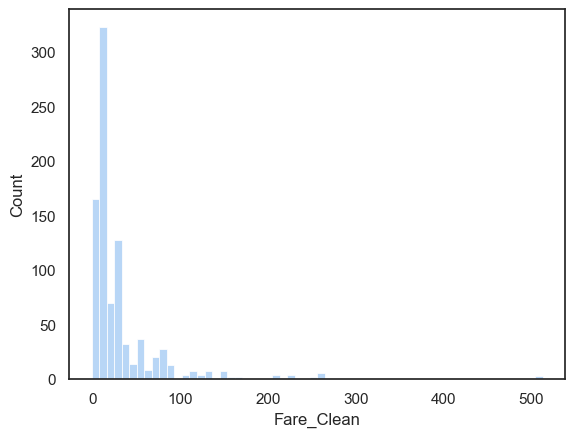

In [243]:
sns.histplot(df, x="Fare_Clean")

<Axes: xlabel='Fare_Clean'>

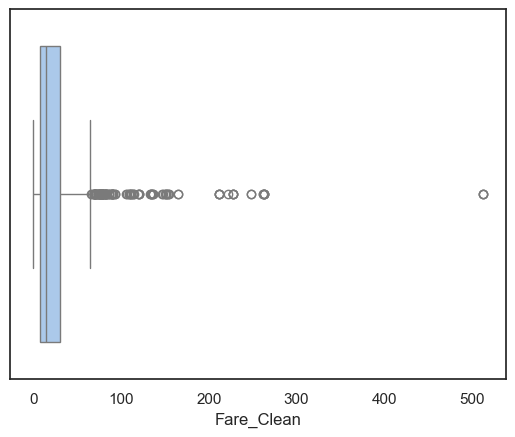

In [244]:
sns.boxplot(df, x="Fare_Clean")

Because `Fare_Clean` is skewed, the mean is not an appropriate representation of the data; therefore, the IQR method is used to replace outliers.

In [245]:
Q1 = df["Fare_Clean"].quantile(0.25)
Q3 = df["Fare_Clean"].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df["Fare_Clean_IQR_Capped"] = df["Fare_Clean"].clip(lower_bound, upper_bound)

In [246]:
filtered_lower_df = df[(df["Fare_Clean"] != df["Fare_Clean_IQR_Capped"]) & (df["Fare_Clean"] < lower_bound)]
filtered_lower_df[["PassengerId", "Fare", "Fare_Clean", "Fare_Clean_IQR_Capped"]].head(3)

,PassengerId,Fare,Fare_Clean,Fare_Clean_IQR_Capped


In [247]:
filtered_upper_df = df[(df["Fare_Clean"] != df["Fare_Clean_IQR_Capped"]) & (df["Fare_Clean"] > upper_bound)]
filtered_upper_df[["PassengerId", "Fare", "Fare_Clean", "Fare_Clean_IQR_Capped"]].head(3)

,PassengerId,Fare,Fare_Clean,Fare_Clean_IQR_Capped
1,2,71.2833,71.094540,65.241703
27,28,263.0000,263.236942,65.241703
31,32,146.5208,147.426295,65.241703


---

# Step 4: Data Transformation
Apply at least one transformation:

- Encode a categorical feature (e.g., one-hot encoding), or
- Create a new feature from existing ones (simple feature engineering), or
- Apply binning to a numerical feature.

Explain what problem this transformation solves.

In [248]:
sex_ohe = pd.get_dummies(df["Sex"])
df = pd.concat([df, sex_ohe], axis=1)

In [249]:
df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Embarked,Age_Clean,Cabin_Clean,Embarked_Clean,Fare_with_Noise,Fare_Clean,Age_Clean_Zcapped,Fare_Clean_IQR_Capped,female,male
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,...,S,22.0,Unknown,S,7.496834,7.439742,22.0,7.439742,False,True
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,...,C,38.0,C85,C,71.214592,71.094540,38.0,65.241703,True,False
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,...,S,26.0,Unknown,S,8.246859,8.115257,26.0,8.115257,True,False
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,...,S,35.0,C123,S,53.856846,53.701287,35.0,53.701287,True,False
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,...,S,35.0,Unknown,S,7.933641,7.860630,35.0,7.860630,False,True


This transformation converts a categorical variable into numerical features so that it can be used by machine learning models that require numeric input.

---

# Step 5: Feature Scaling
1. Select 2–3 numerical features.
2. Apply:
    - Standardization (Z-score)
    - Normalization (Min–Max scaling)
3. Compare the scaled values and explain:
    - When Z-score is preferred
    - When Min–Max scaling is preferred

In [250]:
# ---------- Z-score (StandardScaler) ----------
z_scaler = StandardScaler()

df[["Age_Zscore", "Parch_Zscore"]] = z_scaler.fit_transform(
    df[["Age_Clean_Zcapped", "Parch"]]
)

# ---------- Min-Max (MinMaxScaler) ----------
mm_scaler = MinMaxScaler()

df[["Age_Minmax", "Parch_Minmax"]] = mm_scaler.fit_transform(
    df[["Age_Clean_Zcapped", "Parch"]]
)

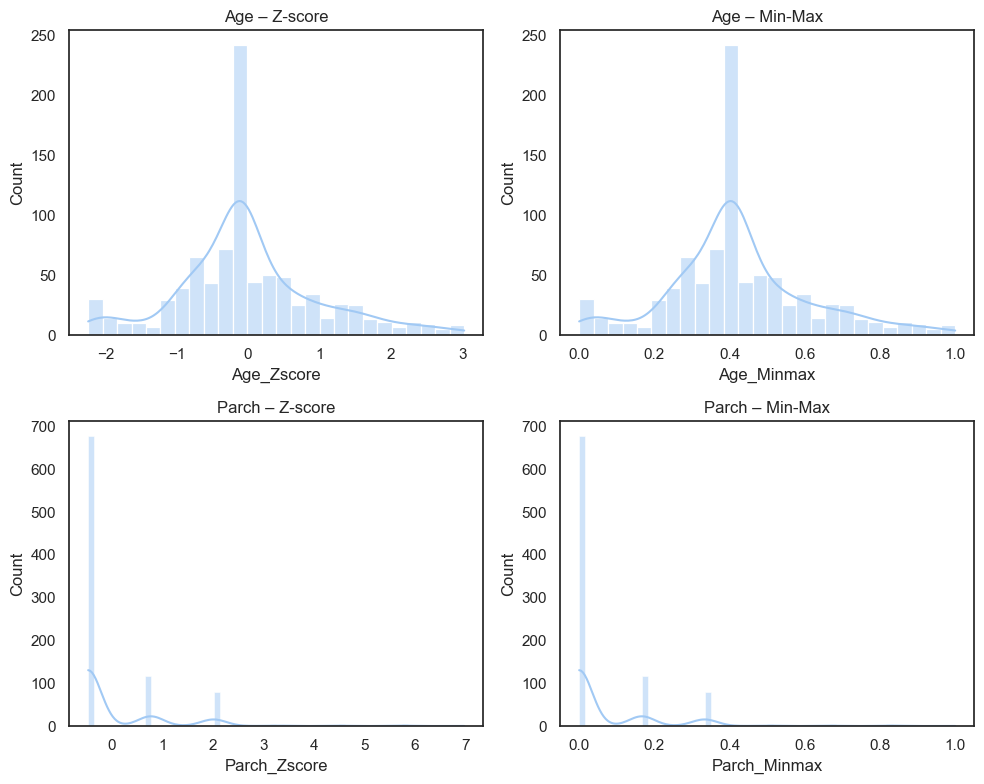

In [253]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

sns.histplot(df["Age_Zscore"], ax=axes[0, 0], kde=True)
axes[0, 0].set_title("Age – Z-score")

sns.histplot(df["Age_Minmax"], ax=axes[0, 1], kde=True)
axes[0, 1].set_title("Age – Min-Max")

sns.histplot(df["Parch_Zscore"], ax=axes[1, 0], kde=True)
axes[1, 0].set_title("Parch – Z-score")

sns.histplot(df["Parch_Minmax"], ax=axes[1, 1], kde=True)
axes[1, 1].set_title("Parch – Min-Max")

plt.tight_layout()
plt.show()

For `Age_Clean_Zcapped`, which is approximately normally distributed, z-score standardization is more suitable because it centers the data at zero and preserves the distribution shape.

For `Parch`, which is left-skewed and bounded, min–max scaling is more appropriate because it maps values into a fixed range without assuming normality.